<h1>Homework 1</h1>

**Ben Priest**

In [1]:
%matplotlib inline

import cProfile as profile
import itertools
import random
import matplotlib.pyplot as plt
import numpy as np
import operator
import scipy.optimize

from mpl_toolkits.mplot3d import Axes3D

<h2>Function to optimize</h2>

We will find all local minima of the function $f: \mathbb{R}^2 \rightarrow \mathbb{R}$, such that 

$$f(y_1,y_2) = 121(2 - y_1^2 - y_2^2 - 3y_1 - 3y_2 + 2 y_1 y_2)^2 + (y_1 - y_2)^2$$

This function was provided in class on 9/30/2015.

In [2]:
def f(y):
    return 121 * (2 - y[0]**2 - y[1]**2 - 3*y[0] - 3*y[1] + 2*y[0]*y[1])**2 + (y[0] - y[1])**2

In [3]:
f([0,0])

484

<h3>Let's plot it!</h3>

Here we plot the function around the origin to get a sense for what it looks like. We will examine both a 3D projection plot and a contour plot.

In [4]:
x = y = np.arange(-1.0, 2.0, 0.01)
X, Y = np.meshgrid(x, y)
zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

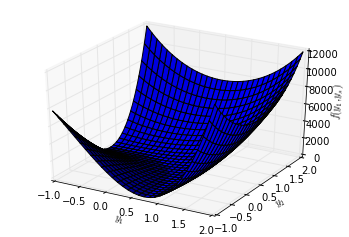

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')
ax.set_zlabel('$f(y_1,y_s)$')

plt.show()

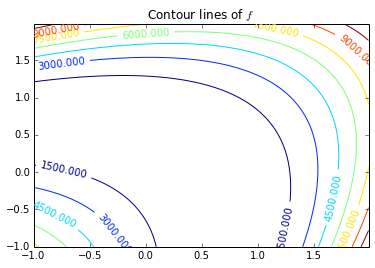

In [6]:
fig = plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Contour lines of $f$')

plt.show()

<h4>Graphical analysis</h4>

It looks as though the function describes a trough surface, similar to the Rosenbrock function (https://en.wikipedia.org/wiki/Rosenbrock_function). It appears as though finding the trough line (the parabola in the plane to which the contour lines above are converging) is fairly trivial, whereas finding the absolute minimum will be more difficult, particularly for an approach line vanilla gradient descent. 

<h2>Gradient Function</h2>

This is the same implementation of the gradient function estimator that I demonstrated in class. It will compute a first order estimation of the gradient of any function $f$ such that $f: \mathbb{R}^n \rightarrow \mathbb{R}$.

In [3]:
def gradient(f, x, eps=0.0001):
    grad = [(f([x[j] + eps if j == i else x[j] for j in range(len(x))]) - f(x))/eps for i in range(len(x))]
    return np.array(grad)

<h2>Hessian Function</h2>

This is an implementation of the a Hessian function estimator. It will compute a first order estimation of the hessian of any function $f$ such that $f: \mathbb{R}^n \rightarrow \mathbb{R}$. It uses the first order estimation of the gradient from the above function.

In [4]:
def hessian(f, x, eps=0.0001):
    hess = [
        (gradient(f, [x[j] + eps if j == i else x[j] for j in range(len(x))], eps=eps) 
         - gradient(f, x, eps=eps))
        /eps for i in range(len(x))]
    return np.array(hess)

<h2>Gradient Descent</h2>

We can now implement gradient descent in the usual way. We will here implement vanilla gradient descent, not varying the $\epsilon$ or $\alpha$ update parameters, and also not checking for convergence. This approach can be easily extended to support a particle swarm or simulated annealing approach.

At each step, we calculate $x_{\textrm{new}} = x_{\textrm{old}} - \alpha \bigtriangledown f(x)$

In [10]:
def vanilla_gd(f, x, epsilon=0.0001, alpha=0.001, its=1000):
    for i in range(its):
        x = map(operator.sub, x, alpha * gradient(f, x, eps=epsilon))
    return x

<h3>Newton's Method</h3>

The following is an implementation of iterated Newton's method applied to find the minimum of a function. 

At each step, we calcluate $x_{\textrm{new}} = x_{\textrm{old}} - (\mathbf{H}f(x))^{-1}f^{\mathbf{T}}(x)$

In [11]:
def newton(f, x, epsilon=0.0001, its=1000):
    for i in range(its):
        hess = hessian(f, x, eps=epsilon)
        grad = gradient(f, x, eps=epsilon)
        x = map(operator.sub, x, np.dot(np.linalg.inv(hess), np.transpose(grad)))
    return x

<h3>Finding the minimum</h3>

Given the graphical analysis above, I can make a guess that the minimum is probably at a point where $y_1 = y_2$, possibly about $y_1 = y_2 = 0.4$. I will guess this value, and run the gradient descent algorithm.

In [6]:
# A good guess, selected on the basisi of visual analysis of the graph.
guess = [0.4,0.4]

# A bad guess, selected from uniform((-1000,1000)x(-1000,1000))
guess_bad = [random.uniform(-1000,1000), random.uniform(-1000,1000)]

Let's try using the default $\epsilon$ and $\alpha$ update parameters that I provided above.

In [13]:
wrong = vanilla_gd(f, guess, epsilon=0.0001, alpha=0.001, its=10)
wrong

[-7045223510.516305, 7036573045.3830442]

**Holy cats!** Those numbers don't look right. Lets evaluate f at this point to see what it looks like.

In [14]:
f(wrong)

4.7579254489610445e+42

Let's try again, this time with a smaller value for the update parameter $\alpha$. 

In [15]:
vanilla_gd(f, guess, epsilon=0.0001, alpha=0.0001, its=10)

[0.3335270001089663, 0.33352700010893338]

In [16]:
f([1/3.0, 1/3.0])

1.4914401489334754e-30

That looks much better. As it turns out, $f(\frac{1}{3},\frac{1}{3}) = 0$ is the global minimum of this function. 

However, I was able to guess well at the outset, which is why I was able to use such a small update parameter. If I were evaluating a function that was too high dimensional to graph, I would not be able to use that intuition. Let's see what would happen if I used a very bad guess.

In [17]:
vanilla_gd(f, guess_bad, epsilon=0.00001, alpha=0.000001, its=1000)

[259042362116641.72, -259042362118744.5]

Seemingly no matter how small I try to make the update parameters, gradient descent swings wildly. This is because of how large the gradient is for bad guesses of this function. 

We could try to ameliorate this problem by expanding upon gradient descent using a simulated annealing or similar approach to modify the update parameter $\alpha$ as we go. 

We will also apply Newton's Method. 

In [18]:
newton(f, guess, epsilon=0.0001, its=12)

[0.33330830954393337, 0.33330830954391477]

So Newton's method also performs well for a good guess for the global minimum. Morever, using the Hessian means that there is no scaling parameter to worry about, as it is a higher-order approximation of the curvature of the function at the given point. 

What about a bad guess?

In [20]:
min_bad = newton(f, guess_bad, epsilon=0.0001, its=1000)
min_bad

[-6.3657148782205484, -14.380302894965604]

Well that didn't work. Let's see how the function behaves around this point. 

In [21]:
f(min_bad)

64.235998094581973

In [22]:
gradient(f, min_bad)

array([ 0.,  0.])

In [23]:
hessian(f, min_bad)

array([[ 87633.12664968, -60000.14519998],
       [-60000.14519998,  41079.7445781 ]])

It looks like this point that Newton's method found was a saddle point. It is in fact on the parabolic trough we examined when we graphed the function above. For the sake of sanity, let's look at the graph around this point.

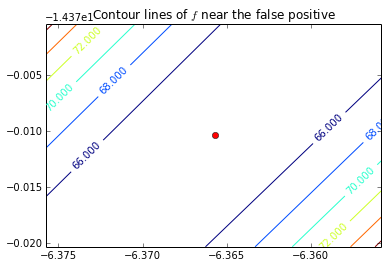

In [24]:
x_bad = np.arange(min_bad[0]-0.01, min_bad[0] + 0.01, 0.0001)
y_bad = np.arange(min_bad[1]-0.01, min_bad[1] + 0.01, 0.0001)
X_bad, Y_bad = np.meshgrid(x_bad, y_bad)
zs_bad = np.array([f([x_bad,y_bad]) for x_bad,y_bad in zip(np.ravel(X_bad), np.ravel(Y_bad))])
Z_bad = zs_bad.reshape(X_bad.shape)

fig = plt.figure()
# plot the countour
CS = plt.contour(X_bad, Y_bad, Z_bad)
# plot the minimum that we found using 
plt.plot(min_bad[0],min_bad[1],'or')
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Contour lines of $f$ near the false positive')

plt.show()

As you can see, dead center of this graph is the point found by the Newton's Method approach. 

The vanilla gradient descent and newton's method approaches are stymied by this function, because the gradient is very large in most places, but very near zero all along this parabolic surface. Newton's method performs slightly better than gradient descent because it is a higher order approximation, but even it has a hard time finding the global maximum if a good guess is not provided.   

<h2>Other optimization methods</h2>

Here we'll try to find the optimum using some other approaches. For the most part, I will not be implementing the methods myself from this point forward. Instead, I'll be using implementations from scipy.optimize, which is a python package that is part of the scipy stack that is similar to the Matlab Optimization Toolkit.  

<h4>Nelder-Mead Method</h4>

This method was employed in class on 10/1/15. It estimates a simplex (an n+1 point polytope in $\mathbb{R}^n$, and uses a deterministic algorithm to expand and contract the simplex iteratively, eventually converging to a minimal solution. 

In [7]:
scipy.optimize.minimize(f,guess_bad)

   status: 0
  success: True
     njev: 204
     nfev: 816
 hess_inv: array([[ 0.12720755, -0.12708461],
       [-0.12708461,  0.12742535]])
      fun: 4.51684189572169e-14
        x: array([ 0.33333331,  0.33333335])
  message: 'Optimization terminated successfully.'
      jac: array([  2.48901709e-06,   2.68317170e-06])

<h4>Linear Least Squares</h4>

